# Chapter 6: Finetuning for Text Classification


In [1]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.3
tiktoken version: 0.8.0
torch version: 2.5.1+cu121
tensorflow version: 2.18.0
pandas version: 2.2.3


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/chapter-overview.webp" width=500px>

## 6.1 不同类别的微调
- 最常见的微调语言模型的方法是指令微调和分类微调。instruction-finetuning and classification finetuning
- 指令微调（如下图所示）是下一章的主题。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/instructions.webp" width=500px>
- 分类微调是本章的主题，如果你有机器学习的背景，可能已经熟悉这个过程——它类似于训练卷积神经网络 convolutional network来分类手写数字。例如，在分类微调中，我们有一组特定的类标签（例如“垃圾邮件”和“非垃圾邮件”），模型可以输出这些类别。
- 分类微调的模型只能预测在训练过程中见过的类别（例如“垃圾邮件spam”或“非垃圾邮件”），而指令微调的模型通常能够执行多种任务。
- 我们可以将分类微调的模型看作是非常专门化的模型；实际上，创建一个专门化模型比创建一个在许多不同任务上表现良好的通用模型要容易得多。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/spam-non-spam.webp" width=500px>

## 6.2 Preparing the dataset
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-1.webp" width=500px>
- 本节准备了用于分类微调的数据集。我们使用一个包含垃圾邮件和非垃圾邮件文本消息的数据集来微调大语言模型（LLM），以便它能够对这些消息进行分类。首先，我们下载并解压该数据集。

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


数据集被保存为一个制表符分隔的文本文件，我们可以将其加载到一个 pandas 的 DataFrame 中。

In [3]:
#使用 sep="\t" 指定文件中的分隔符为制表符；
#header=None 表示文件没有表头，即每行数据从第一列开始；
#names=["Label", "Text"] 为列命名，将第一列设为“Label”表示邮件类型，第二列设为“Text”表示邮件内容。

import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- 当我们检查类别分布时，可以看到数据中“ham”（即“非垃圾邮件”）的频率远高于“spam”（垃圾邮件）。


In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 为了简单起见，也为了教育目的而使用一个较小的数据集（这样可以更快地微调大语言模型），我们对数据集进行子抽样（下采样），使每个类别包含747个实例。
- （除了下采样之外，还有其他多种处理类别不平衡的方法，但这些方法超出了本书关于大语言模型的讨论范围；在 imbalanced-learn 用户指南中可以找到更多信息和示例。）

In [5]:
def create_balanced_dataset(df):
    
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- 接下来，我们将字符串形式的类别标签“ham”和“spam”转换为整数类别标签0和1。

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})


- 现在，我们定义一个函数，将数据集随机划分为训练集、验证集和测试集。

In [7]:
#原始数据集 df 划分为训练集、验证集和测试集，并将结果保存为 CSV 文件
#pandas DataFrame（df），以及训练集和验证集的比例（train_frac 和 validation_frac）作为参数
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame  打乱数据
    # frac=1 表示返回所有行的打乱顺序
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices 计算划分索引
    #train_end 是训练集的结束索引，
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame  划分数据集
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

#将 balanced_df 划分成训练集（70%）、验证集（10%），剩下的 20% 自动作为测试集。
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 Creating data loaders

- 请注意，这些短信的长度不一致；如果我们想在一个批次中组合多个训练样本，则需要：
    - 将所有消息截断到数据集或批次中最短消息的长度，
    - 或将所有消息填充到数据集或批次中最长消息的长度。
我们选择了选项2，将所有消息填充到数据集中最长消息的长度。 pad all messages to the longest message
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/pad-input-sequences.webp?123" width=500px>

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 下面的 SpamDataset 类识别出训练数据集中最长的序列，并向其他消息添加填充标记，以匹配该序列的长度。

In [9]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    #                   数据集文件                              填充pad的ID      
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        #求最长的length
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            #pad加在最后面
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    #使数据集对象可以像列表一样使用索引访问数据（例如，dataset[0]），并返回一个样本的输入特征和标签。
    def __getitem__(self, index):
        #指定索引位置的编码文本的token id
        encoded = self.encoded_texts[index]
        #从原始数据框 self.data 中提取对应 index 行的标签。这里假设标签在数据框的 "Label" 列中。
        #在上面的例子中，label列是spam 或者non-spam
        label = self.data.iloc[index]["Label"]
        return (
            #将编码文本和标签转换为 torch.tensor 格式，确保数据类型为 long，适合 PyTorch 模型处理
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        #返回数据集的长度，即样本数量
        return len(self.data)

    #找最长的length
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [10]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- 我们也将验证集和测试集填充到与最长训练序列相同的长度。
- 请注意，验证集和测试集中的样本如果比最长的训练样本还长，则会在 SpamDataset 代码中通过 encoded_text[:self.max_length] 进行截断。
- 此行为完全是可选的，即使在验证集和测试集中将 max_length 设置为 None 也可以正常工作。

In [11]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

- 下面使用数据集实例化data loader，这与之前章节中创建数据加载器的方法类似。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/batch.webp" width=500px>

In [ ]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- 作为验证步骤，我们遍历数据加载器，确保每个批次包含8个训练样本，每个训练样本由120个标记组成。

In [13]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- 最后，让我们打印每个数据集中的批次数量。

In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 使用预训练权重初始化模型
- 在本节中，我们初始化了上一章使用的预训练模型。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-2.webp" width=500px>

In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [16]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)  #实例化
load_weights_into_gpt(model, params)   #给GPT加载权重
model.eval();           #评估模式

checkpoint: 100%|██████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<?, ?iB/s]
encoder.json: 100%|███████████████████████████████████████████████████████████████| 1.04M/1.04M [00:03<00:00, 327kiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<?, ?iB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████████████████████████| 498M/498M [04:29<00:00, 1.85MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<?, ?iB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:01<00:00, 313kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:01<00:00, 275kiB/s]


- 为了保证模型正确加载，再次检查一下是否产生合乎情理的文本

In [17]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 在微调模型变成分类器之前，看看模型是不是能通过prompt进行spam分类

In [18]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


- 可以看到，该模型在执行指令时表现并不理想。这是预期的，因为它仅经过了预训练，而未经过指令微调（指令微调将在下一章介绍）。

##  6.5 Adding a classification head
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/lm-head.webp" width=500px>
- 修改预训练的LLM来进行分类微调
- 看一下模型结构

In [19]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 上面我们可以看到我们在第4章中实现的架构被整齐地列了出来。
- 目标是替换并微调输出层。
- 为了实现这一点，我们首先冻结模型，即将所有层设置为不可训练状态。

In [20]:
for param in model.parameters():
    param.requires_grad = False

- 然后，我们替换输出层（model.out_head），它原本将层的输入映射到50,257个维度（即词汇表的大小）。
- 由于我们微调模型进行二分类（预测2个类别，“垃圾邮件”和“非垃圾邮件”），我们可以按如下方式替换输出层，该层默认是可训练的。
- 注意，我们使用 BASE_CONFIG["emb_dim"]（在"gpt2-small (124M)"模型中等于768）以使下面的代码更具通用性。

In [21]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- 技术上来说，只训练输出层就足够了。
- 然而，正如我在《微调大型语言模型》中发现的那样，实验表明微调额外的层可以显著提高性能。
- 因此，我们还使最后一个transformer块和连接最后一个transformer块到输出层的最终LayerNorm模块变为可训练的。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/trainable.webp" width=500px>

In [22]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

- 我们仍然可以像前几章一样使用这个模型。
- 例如，让我们给它一些文本输入。

In [23]:
inputs = tokenizer.encode("Do you have time")
## 将编码后的 token 序列转换为 PyTorch tensor，以便在模型中进行进一步处理
#.unsqueeze(0) 在 tensor 的第0维（最前面）增加了一个新的维度，用来表示批处理的大小（batch size）。
#由于这里只有一个输入句子，unsqueeze(0) 的结果是形状 (1, num_tokens)，其中 1 表示批大小。
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- 和前几章不同的是 输出维度是2，而不是50257

In [25]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


- 如前几章所讨论的，对于每个输入token，都有一个输出向量。
- 由于我们为模型提供了一个包含4个输入token的文本样本，输出由4个2维输出向量组成。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/input-and-output.webp" width=500px>
- 在第3章中，我们讨论了注意力机制，该机制将每个输入token与其他输入token连接起来。
- 在第3章中，我们还介绍了GPT类模型中使用的因果注意力掩码causal attention mask ；这种因果掩码使得当前token只能关注当前及之前的token位置。
- 基于这种因果注意力机制，第4个（最后一个）token包含了所有token中最多的信息，因为它是唯一包含所有其他token信息的token。
- 因此，我们对这个最后一个token特别感兴趣，我们将微调它用于垃圾邮件分类任务。

In [26]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


- <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/attention-mask.webp" width=200px>

## 6.6 Calculating the classification loss and accuracy
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-3.webp?1" width=500px>
- 在解释损失计算之前，让我们先简单了解一下如何将模型输出转化为类别标签。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/class-argmax.webp" width=600px>

In [27]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


- 与第 5 章类似，我们通过 softmax 函数将输出（logits）转换为概率分数，然后通过 argmax 函数获取最大概率值的索引位置。

In [28]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


- 注意，这里 softmax 函数是可选的（在第 5 章中已解释过），因为最大输出值对应于最大概率分数。

In [29]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


- 我们可以应用这一概念来计算所谓的分类准确率，该准确率计算给定数据集中正确预测的百分比。
- 为了计算分类准确率，我们可以将前面的基于 argmax 的预测代码应用于数据集中的所有示例，并计算正确预测的比例，如下所示：

In [30]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()  #评估模式
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- 将这个函数用于计算不同数据集的classification accuracies

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Running on cuda device.
Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- 可以看到，预测准确率不是很高，因为我们尚未微调模型。
- 在我们开始微调（训练）之前，我们首先必须定义在训练过程中希望优化的损失函数。

- 目标是最大化模型的垃圾邮件分类准确率；然而，分类准确率不是一个可微分的函数。

- 因此，我们通过最小化交叉熵损失cross-entropy loss来代替最大化分类准确率（可以在我免费提供的深度学习导论课程的第 8 讲中了解更多有关此主题的内容）。
- 这里的 calc_loss_batch 函数与第 5 章中的相同，只是我们只关注优化最后一个 `token model(input_batch)[:, -1, :]` 而不是所有 `tokens model(input_batch)`。

In [32]:

#只计算最后一个token的，因为他包含前面文本的所有信息
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [33]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 使用 calc_loss_loader，我们在开始训练之前计算初始的训练集、验证集和测试集损失。

In [34]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


- 在下一节中，我们将训练模型以改进损失值，从而提高分类准确率。

## 6.7 Finetuning the model on supervised data
- 在本节中，我们定义并使用训练函数来提高模型的分类准确率。
- 下面的 train_classifier_simple 函数实际上与我们在第 5 章中用于预训练模型的 train_model_simple 函数几乎相同。

- 唯一的两个不同之处在于：

    - 我们现在跟踪看到的训练样本数（examples_seen），而不是看到的 tokens 数量。
    - 每个 epoch 结束后计算准确率，而不是每个 epoch 结束后打印示例文本。
<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/training-loop.webp?1" width=500px>

In [35]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    ## 初始化列表以跟踪训练和验证损失以及准确率
    #losses 用于存储训练和验证损失，accs 用于存储训练和验证的准确率
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1  # 用于记录已处理的样本数和全局训练步数

    # Main training loop
    for epoch in range(num_epochs):
        model.train()   # 设置模型为训练模式

        # 逐批次处理训练数据
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 清除上次迭代的梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 反向传播计算梯度
            optimizer.step() # 使用梯度更新模型权重
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # 每隔 `eval_freq` 步进行一次可选评估
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

         # 每个 epoch 结束时计算训练和验证集的准确率
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- The `evaluate_model` function used in the `train_classifier_simple` is the same as the one we used in chapter 5

In [36]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- The training takes about 5 minutes on a M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [37]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.87 mi

In [38]:
#画图matplotlib看一下损失函数
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

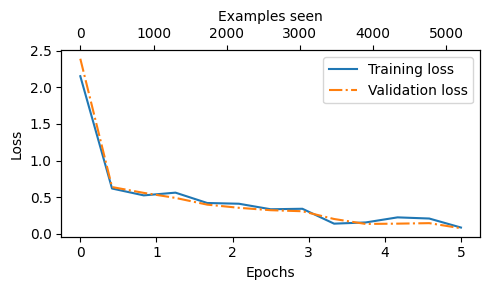

In [39]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- 上面，根据下降的曲线斜率，可以看出模型学习效果良好。
- 此外，训练损失和验证损失非常接近，这表明模型没有明显地过拟合训练数据。
- 同样地，我们可以在下方绘制准确率图。

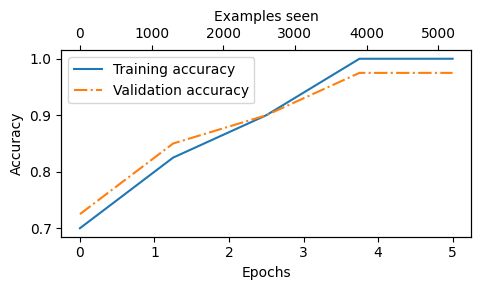

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- 从上方的准确率图可以看到，模型在第4和第5个周期后达到了相对较高的训练和验证准确率。
- 不过需要注意的是，我们在之前的训练函数中指定了eval_iter=5，这意味着我们只是估算了训练和验证集的性能。
- 我们可以如下计算整个数据集上的训练、验证和测试集性能。

In [41]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


- 可以看到，训练集和验证集的性能几乎是相同的。
- 然而，根据略低的测试集性能，可以看出模型在一定程度上过拟合了训练数据，以及用于调整一些超参数（例如学习率）的验证数据。
- 这是正常现象，可以通过增加模型的dropout率（drop_rate）或优化器设置中的weight_decay来进一步减小这种差距。

## 6.8 Using the LLM as a spam classifier
- <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-4.webp" width=500px>
- 最后，让我们实际使用微调后的GPT模型。
- 下方的classify_review函数实现了类似于之前SpamDataset中的数据预处理步骤。
- 然后，该函数从模型中返回预测的整数类别标签，并返回对应的类别名称。

In [42]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()# 设置模型为评估模式，确保不会更新权重

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    # 获取模型支持的最大序列长度
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate截断 sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    #转化为张量
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference 模型推理
    with torch.no_grad():   # 关闭梯度计算以节省内存
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

In [43]:
#下面进行测试

text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [44]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


- 保存模型，如果以后需要再次使用，不需要再训练

In [45]:
torch.save(model.state_dict(), "review_classifier.pth")

- 在新的session，会像如下加载模型

In [46]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>